In [1]:
import torch
import pandas as pd
import numpy as np
from transformer import VanillaTimeSeriesTransformer_EncoderOnly
from utils import Trainer, preprocess_data, seed_everything
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll import scope
import pickle
from collections import OrderedDict

seed_everything()

# Vanilla Transformer (Next Step Prediction | Encoder only)

### Hyperparamer Tuning (Structural Tuning Too) for 2 Features

In [ ]:
df = pd.read_csv("../data/Final_data_hourly.csv")
df

In [ ]:
df = df[["close", "open"]]
input_seq_len_ = 36
output_seq_len_ = 1
scaled_df, scaler_general, scaler_close, train_dataloader, val_dataloader, test_dataloader = preprocess_data(df,
                                                                                                             batch_size = 256,
                                                                                                             input_seq_len=input_seq_len_,
                                                                                                             output_seq_len=output_seq_len_)
def objective(params):
    print(f"""
    device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')},
    num_heads:  {params['num_heads']},
    d_model: {params['d_model_by_num_heads'] * params['num_heads']},
    num_layers: {params['num_layers']},
    dff: {params['dff']},
    mlp_size: {params['mlp_size']},
    dropout_rate: {params['dropout_rate']},
    mlp_dropout_rate: {params['mlp_dropout_rate']}""")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Use the parameters to define your model, train it and evaluate it.
    num_heads = params['num_heads']
    d_model = params['d_model_by_num_heads'] * num_heads
    model = VanillaTimeSeriesTransformer_EncoderOnly(
        num_features=int(len(scaled_df.columns)),
        num_layers=params['num_layers'],
        d_model=d_model,
        num_heads=num_heads,
        dff=params['dff'],
        input_seq_len=36,
        output_seq_len=1,
        mlp_size=params['mlp_size'],
        dropout_rate=params['dropout_rate'],
        mlp_dropout_rate=params['mlp_dropout_rate']
    )
    model = model.to(device)

    optimiser = Adam(model.parameters(), lr=params['lr'])
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.9, patience=5)
    criterion = MSELoss()
                 
    model_trainer = Trainer(model=model,
                    train_dataloader=train_dataloader,
                    val_dataloader=val_dataloader,
                    test_dataloader=test_dataloader,
                    criterion=criterion,
                    optimiser=optimiser,
                    scheduler=scheduler,
                    device=device,
                    num_epochs=50,
                    early_stopping_patience_limit=10,
                    is_save_model=True,
                    scaler=scaler_close)

    train_losses, val_losses = model_trainer.train_loop()

    # Return the last validation loss from the training loop
    return {'loss': val_losses[-1], 'status': STATUS_OK}

space = {
    'num_layers': scope.int(hp.quniform('num_layers', 1, 8, 1)),
    'num_heads': scope.int(hp.quniform('num_heads', 1, 8, 1)),
    'd_model_by_num_heads': scope.int(hp.quniform('d_model_by_num_heads', 32, 64, 2)),
    'dff': scope.int(hp.quniform('dff', 2, 2048, 1)),
    'mlp_size': scope.int(hp.quniform('mlp_size', 32, 64, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.3),
    'mlp_dropout_rate': hp.uniform('mlp_dropout_rate', 0.1, 0.3),
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.1))
}

# Run the optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print(best)

with open('../data/stats_on_hyperparam_for_now_two_cols_vanilla_transformer_hourly.pkl', 'wb') as file:
    pickle.dump(best, file)


### Finding Top Features

In [6]:
seed_everything()
df = pd.read_csv("../data/Final_data_hourly.csv")
with open('../data/stats_on_hyperparam_for_now_two_cols_vanilla_transformer_hourly.pkl', 'rb') as file:
    best = pickle.load(file)

high
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 2403675.25, Test MAE: 1298.80908203125


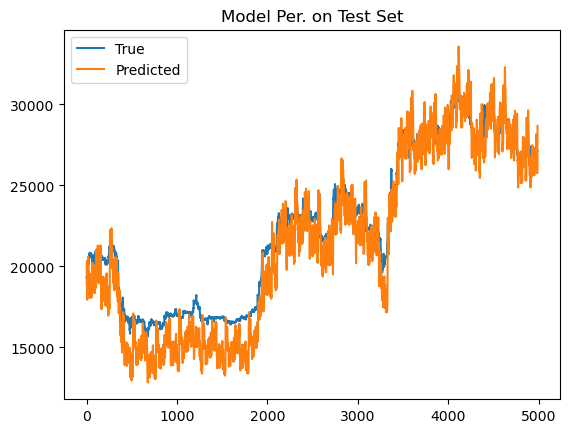

low
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 2413494.0, Test MAE: 1279.848876953125


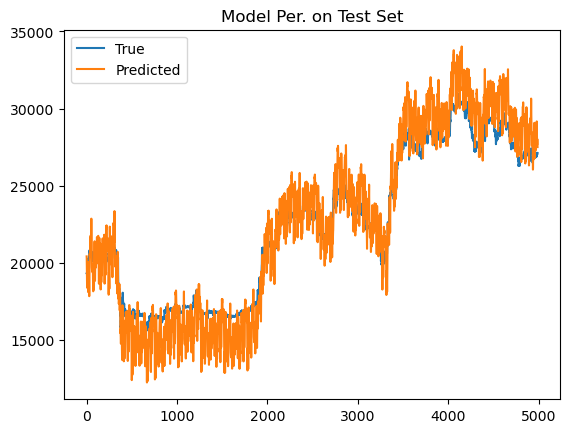

open
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 3367994.25, Test MAE: 1497.09716796875


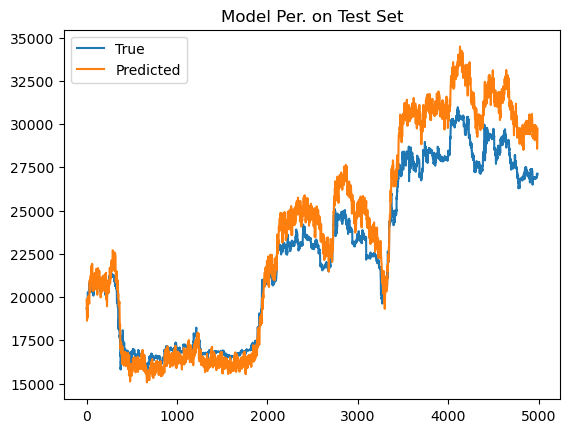

forex_sentiment_score
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 5904541.5, Test MAE: 1903.3726806640625


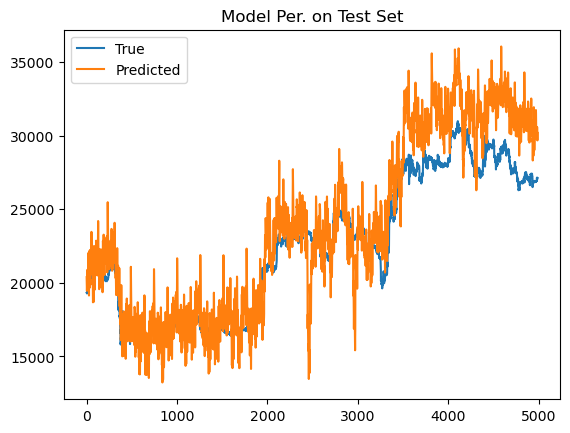

forex_total
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 4433330.5, Test MAE: 1722.24072265625


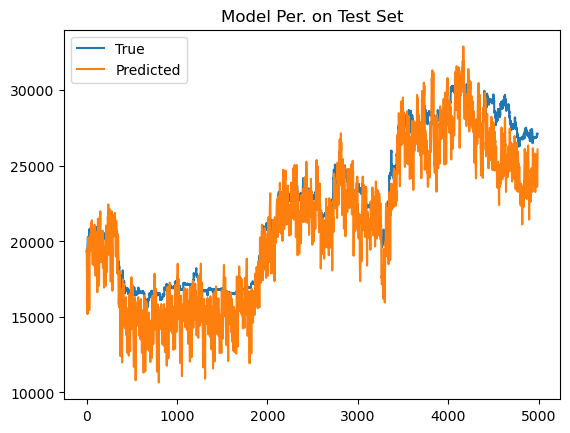

stock_sentiment_score
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 4890437.5, Test MAE: 1865.151611328125


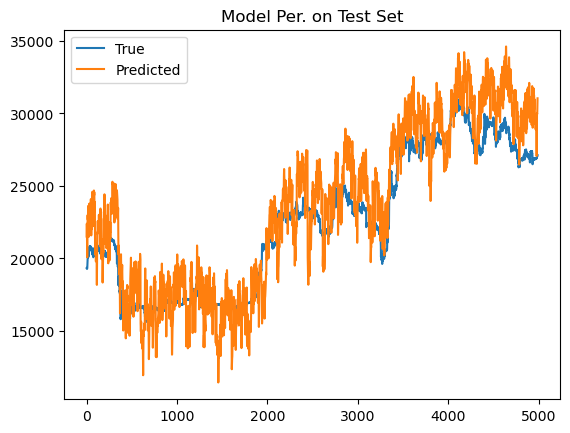

stock_total
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 9622573.0, Test MAE: 2736.656494140625


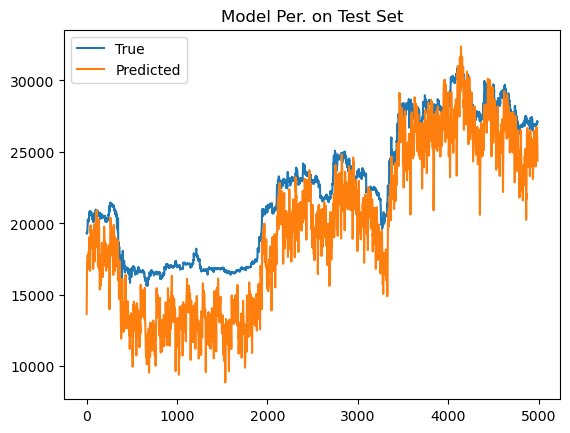

btc_sentiment_score
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 3811248.75, Test MAE: 1617.9107666015625


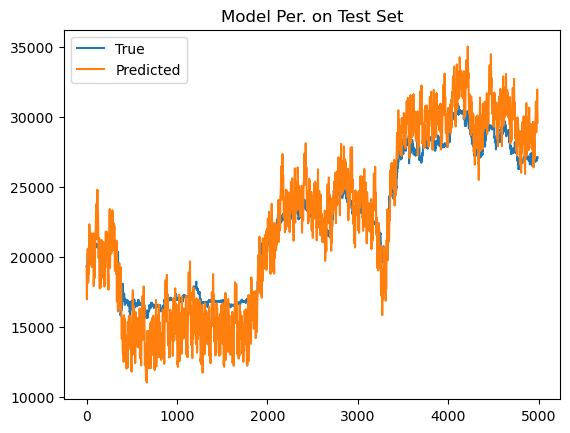

btc_Total
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 4064865.0, Test MAE: 1758.592041015625


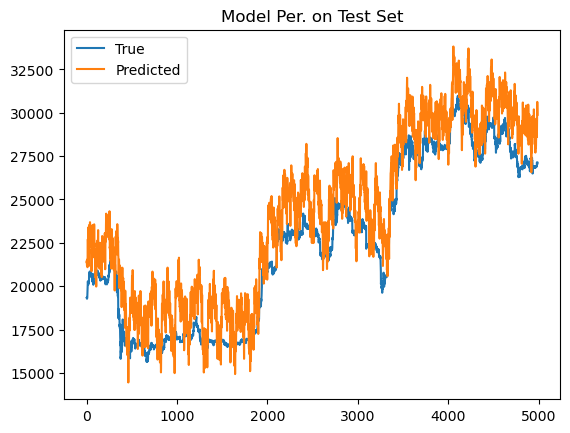

eth_sentiment_score
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 3864492.25, Test MAE: 1610.614990234375


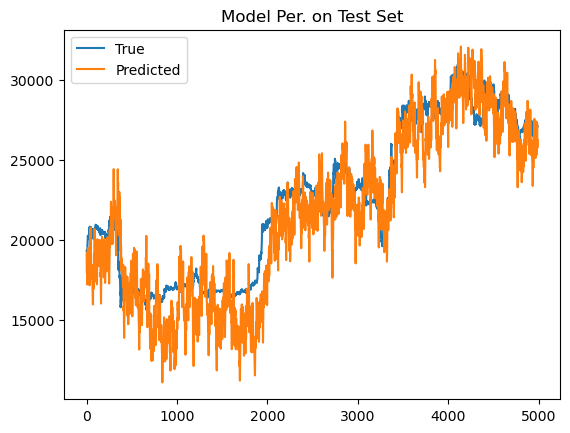

eth_Total
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 4025987.75, Test MAE: 1636.2115478515625


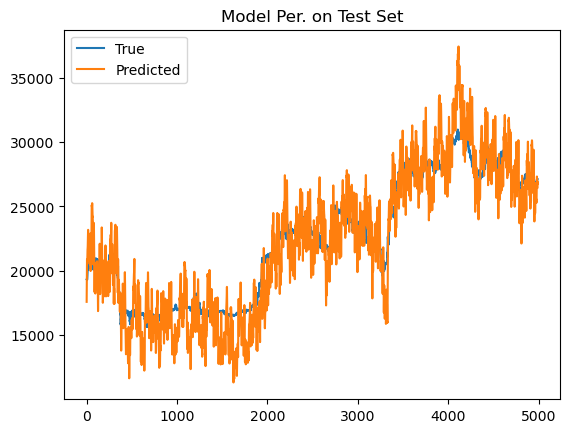

Hash Rate
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 15077555.0, Test MAE: 3575.28271484375


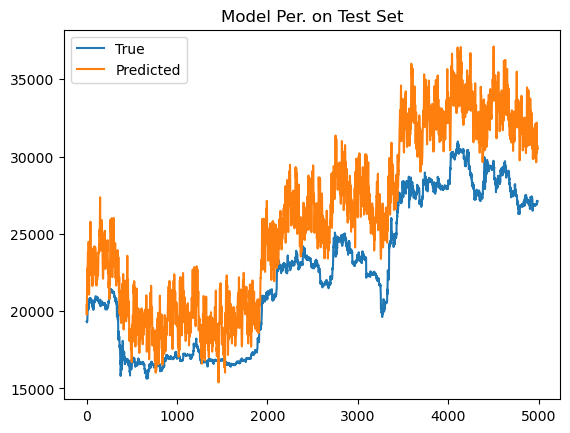

Active Addresses
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 3223383.25, Test MAE: 1469.677734375


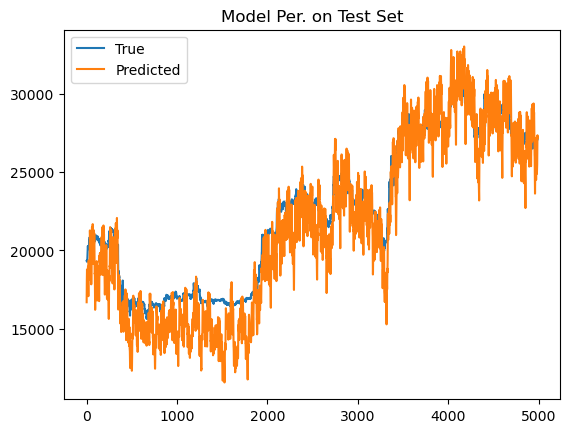

Transaction Size (Total)
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 2789958.5, Test MAE: 1249.1331787109375


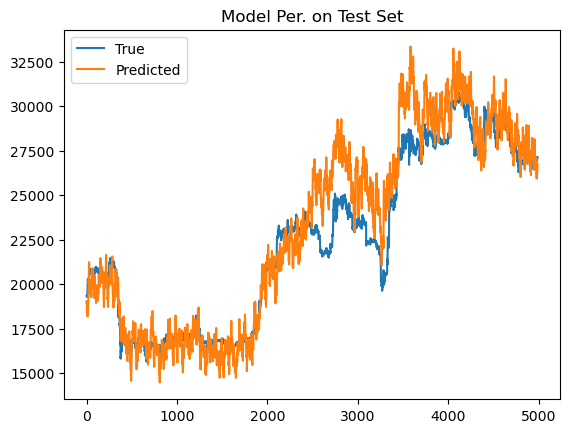

Exchange Withdrawals
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 2370199.0, Test MAE: 1285.5406494140625


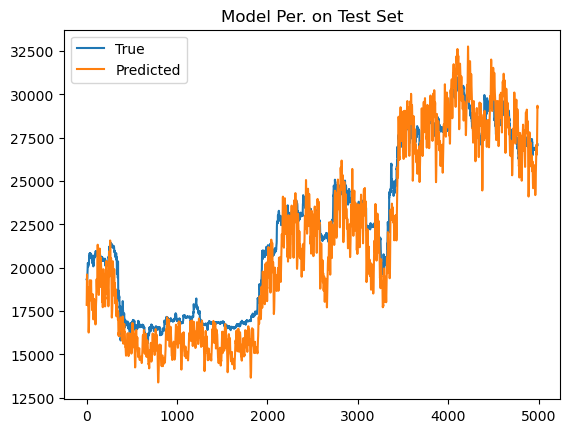

Difficulty
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 847706.0, Test MAE: 763.252197265625


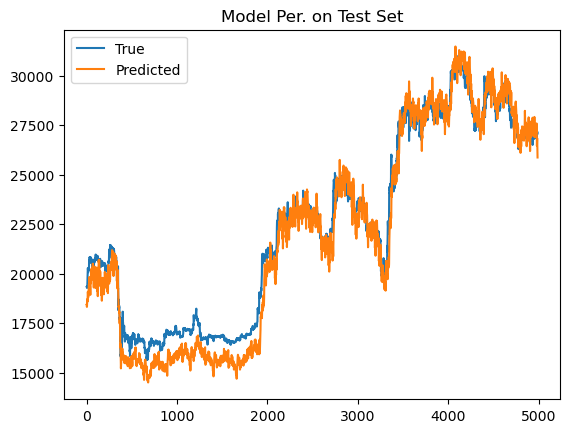

Transfer Volume (USDT)
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 1285280.25, Test MAE: 915.6187133789062


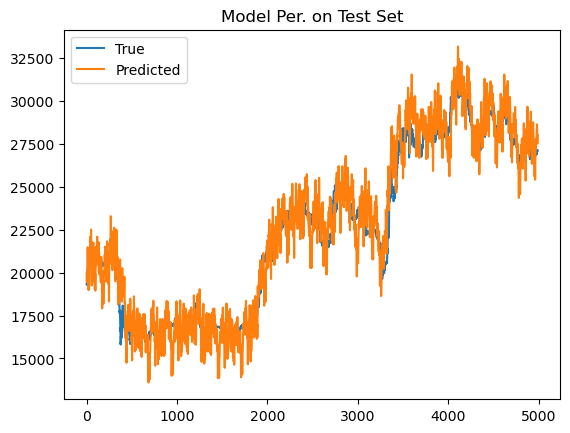

Market Cap
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 6295763.0, Test MAE: 2143.083251953125


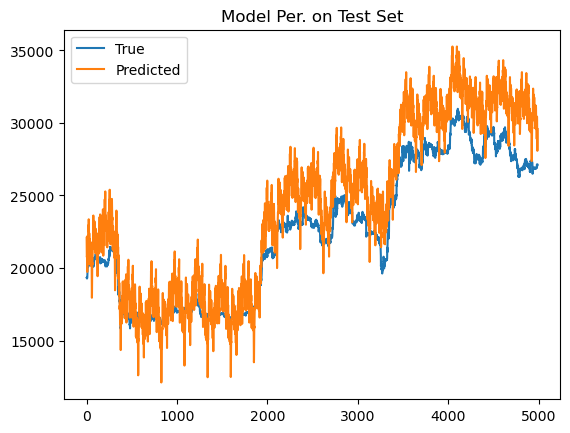

Exchange Inflow Volume (Total) (USDT)
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 1625697.875, Test MAE: 999.2247314453125


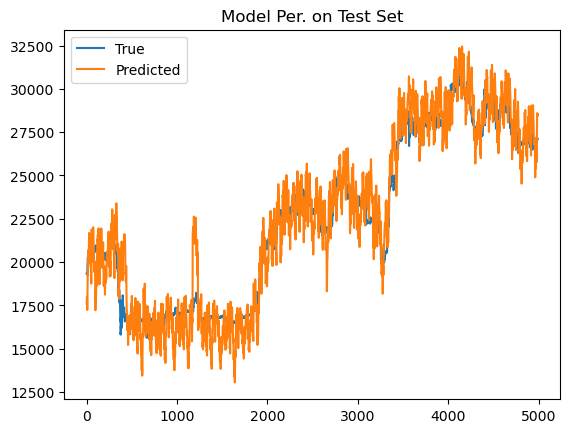

Exchange Outflow Volume (Total) (USDT)
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 2887382.25, Test MAE: 1344.3114013671875


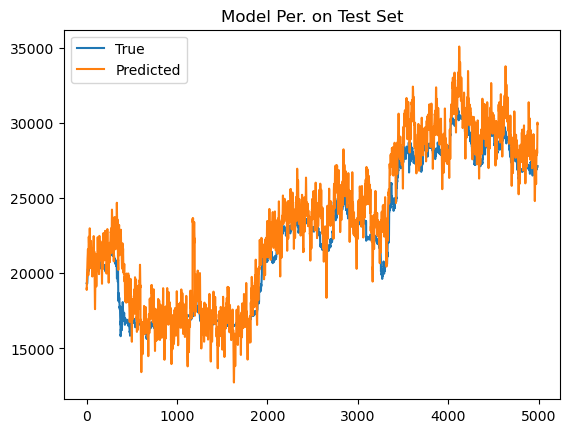

Circulating Supply
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 36927520.0, Test MAE: 5976.06298828125


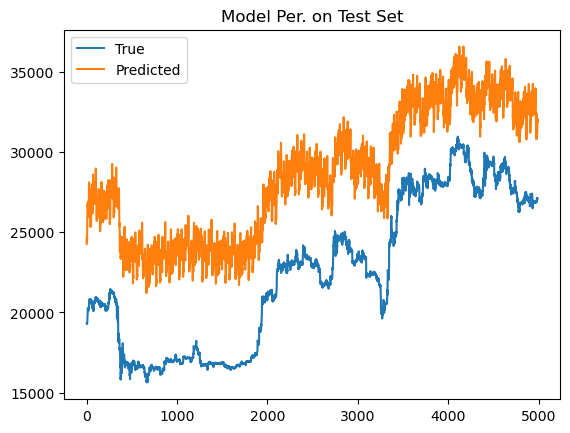

Price (ETH)
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 7302431.5, Test MAE: 2447.822021484375


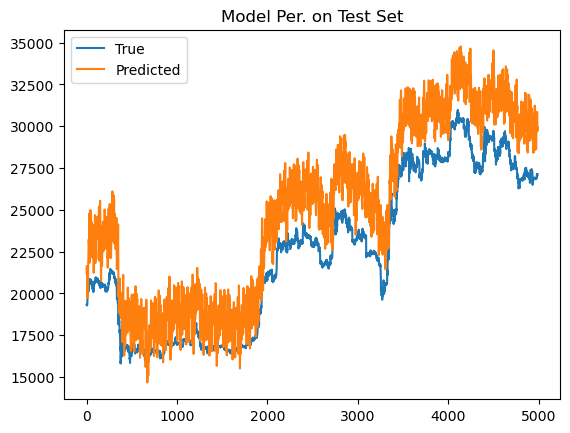

Price (LTC)
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 3502405.25, Test MAE: 1582.68359375


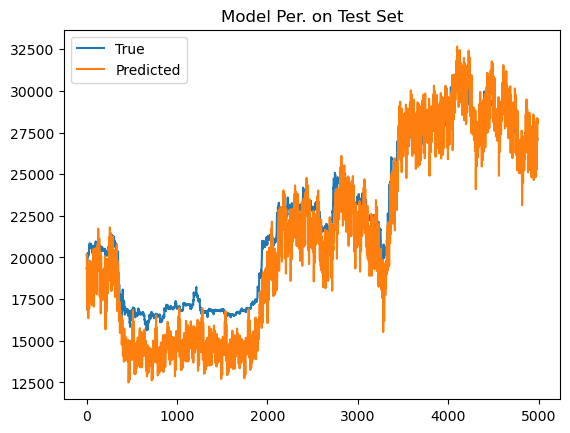

Realized Cap HODL Waves 7y_10y
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 2781982.5, Test MAE: 1425.4466552734375


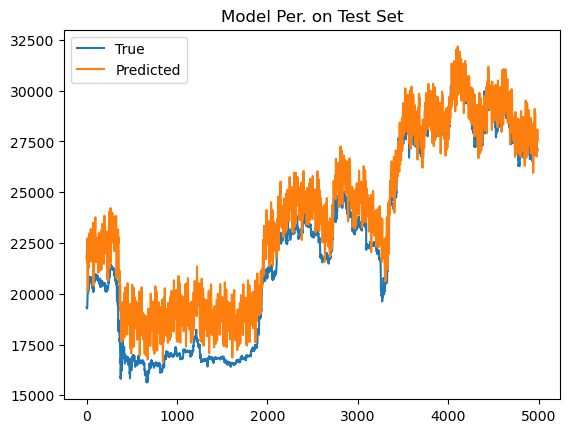

Stock-to-Flow Ratio price
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 6099514.5, Test MAE: 2137.8046875


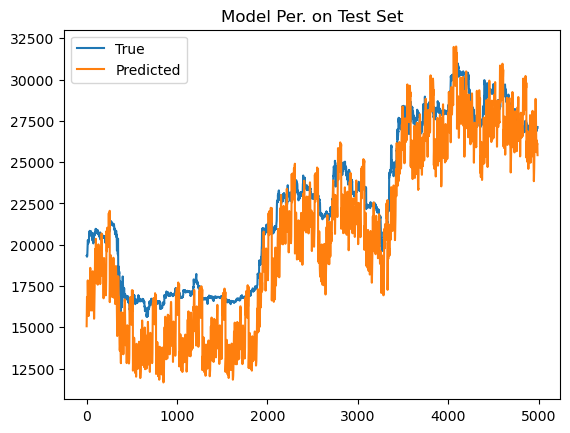

Stock-to-Flow Ratio ratio
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 2239805.0, Test MAE: 1416.4549560546875


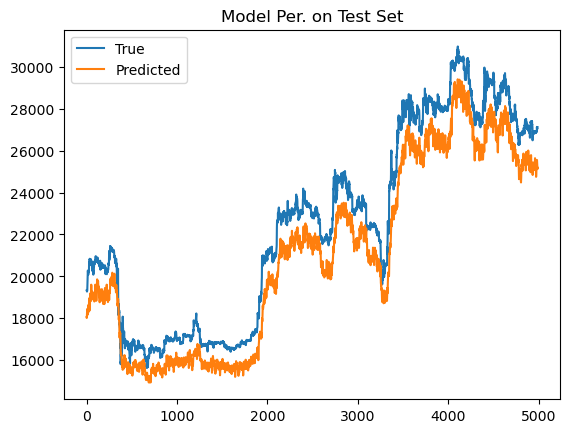

000001.SS
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 1827377.875, Test MAE: 1117.0911865234375


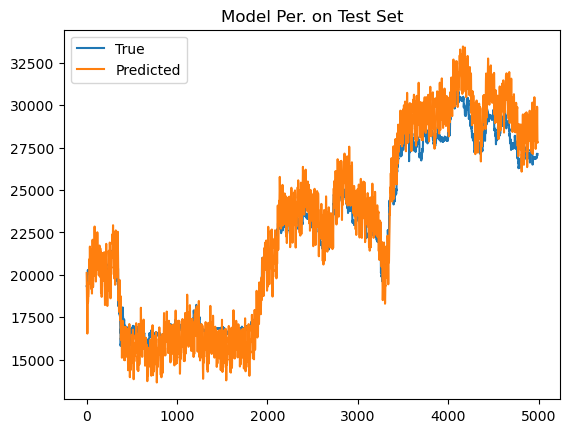

^AXJO
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 1490461.375, Test MAE: 1022.4308471679688


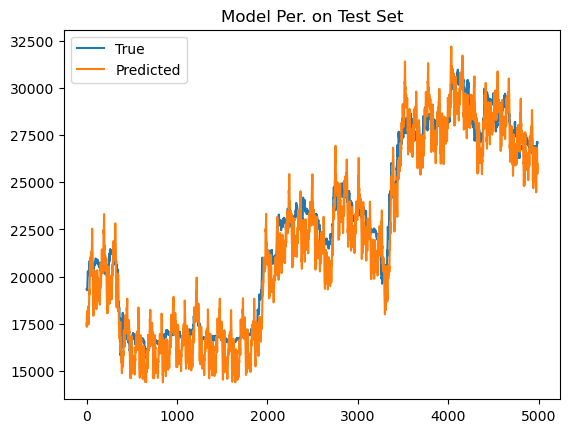

^DJI
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 5890088.0, Test MAE: 2198.87646484375


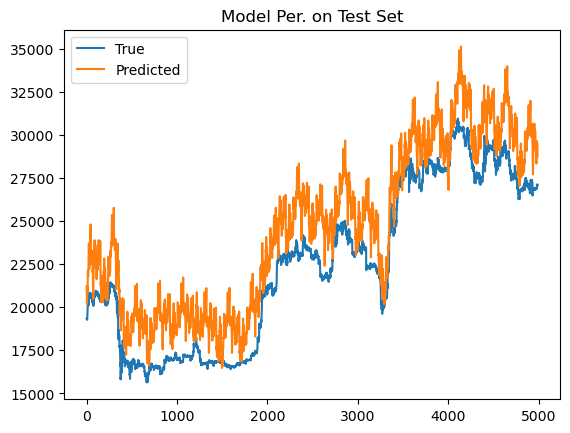

^FTSE
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 6496488.0, Test MAE: 2154.400146484375


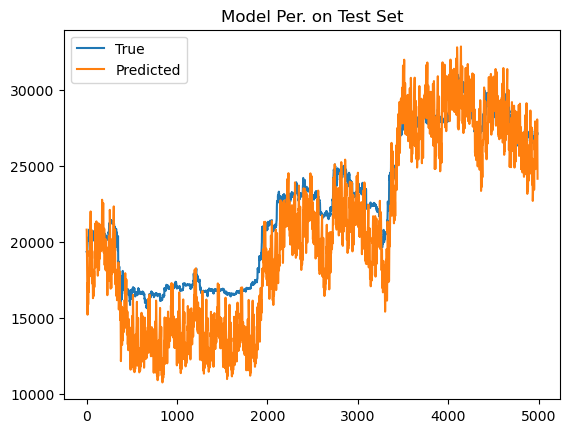

^GDAXI
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 16277330.0, Test MAE: 3684.747314453125


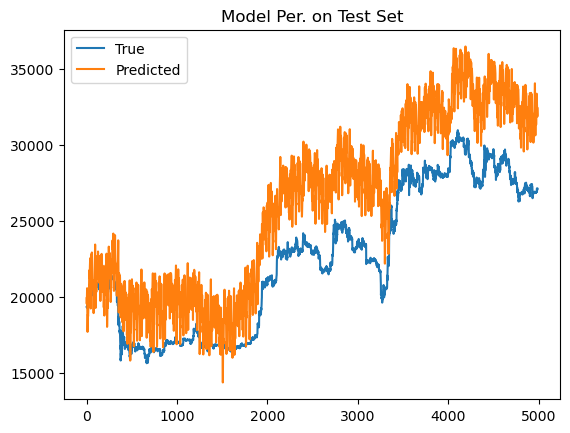

^GSPC
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 1297045.625, Test MAE: 909.2160034179688


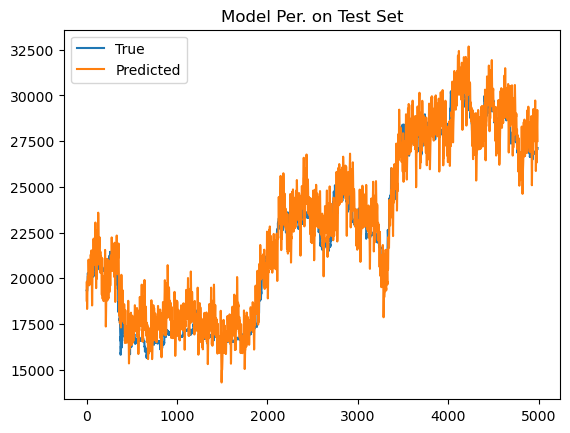

^IXIC
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 3349078.25, Test MAE: 1443.0250244140625


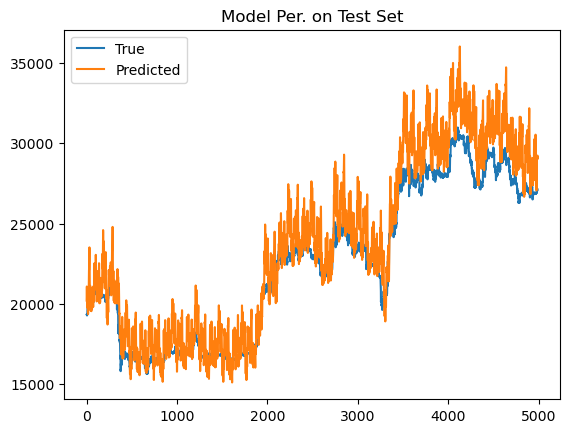

^N225
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 1526763.75, Test MAE: 1015.4613037109375


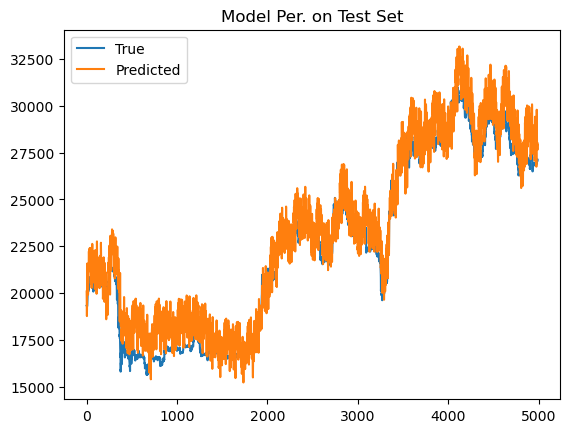

^VIX
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 9378562.0, Test MAE: 2718.26513671875


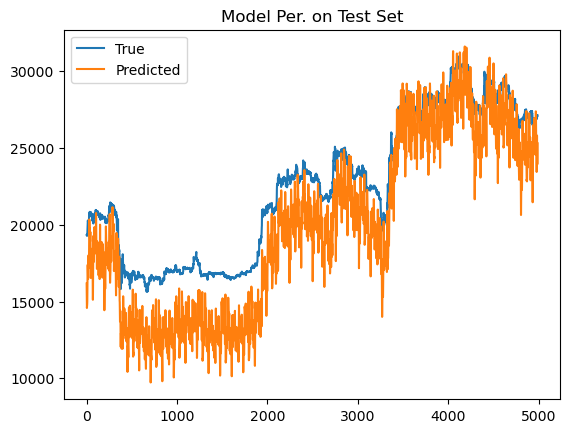

CL=F
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 1736304.25, Test MAE: 1027.1761474609375


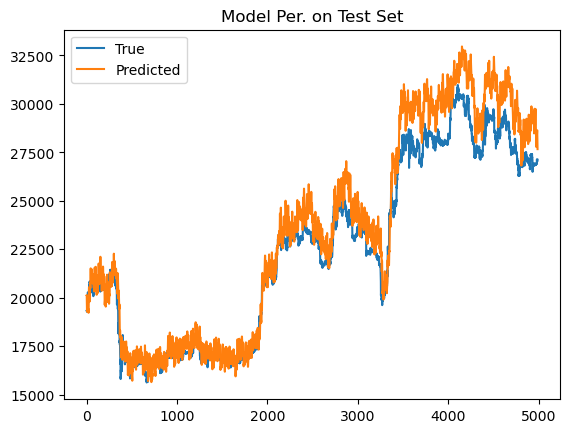

GC=F
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 2785744.0, Test MAE: 1337.28466796875


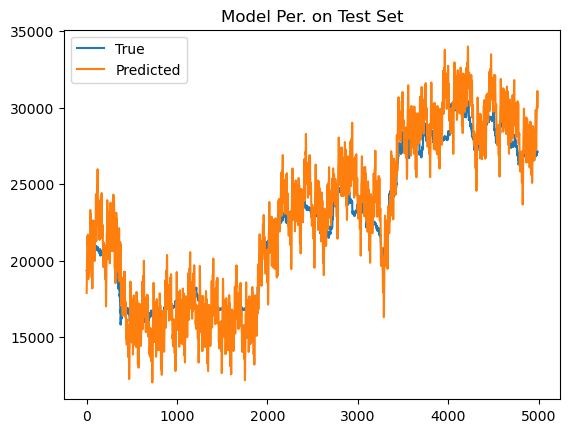

NG=F
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 4208218.5, Test MAE: 1714.3658447265625


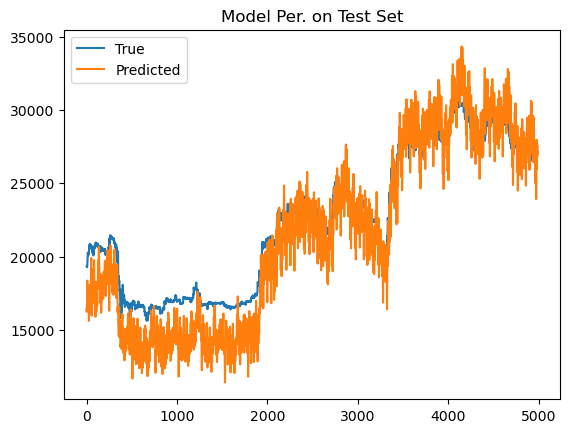

SI=F
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 1582111.0, Test MAE: 1020.4425659179688


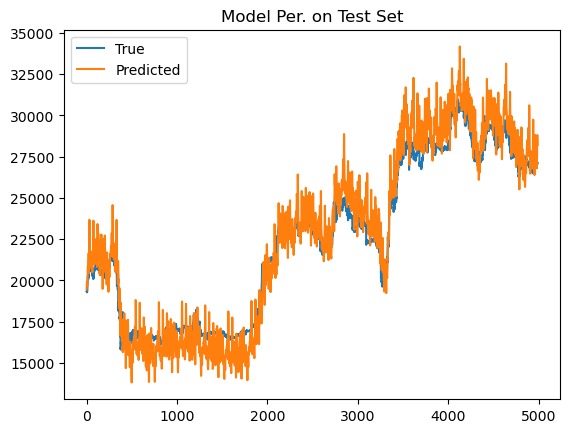

ZW=F
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 5270343.0, Test MAE: 1973.0206298828125


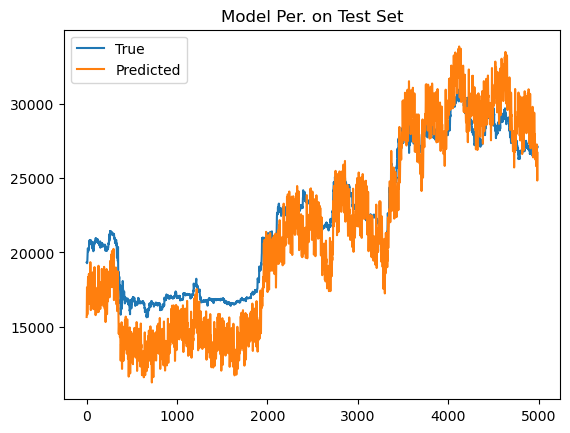

DFF
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 9377916.0, Test MAE: 2714.529296875


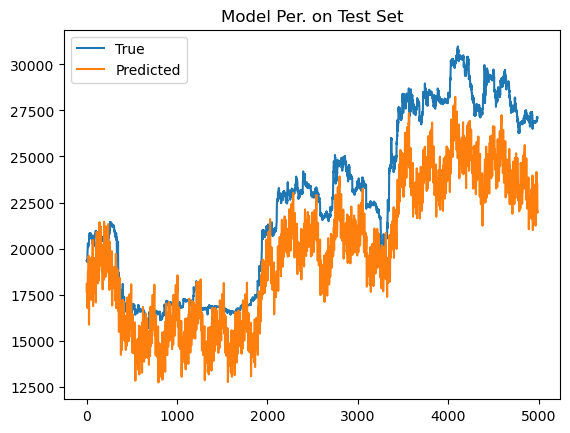

CPIAUCSL
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 19699760.0, Test MAE: 4287.17626953125


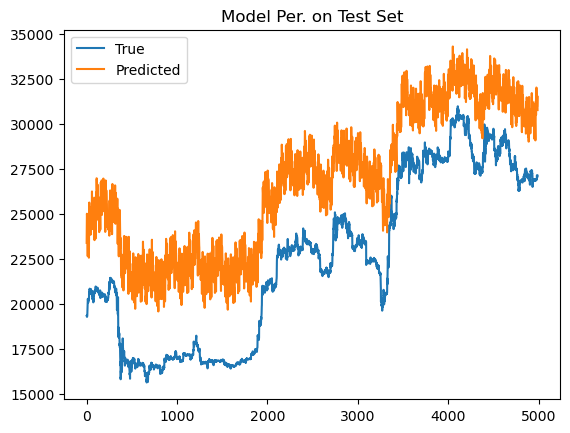

SMA_24_hourly
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 3140875.0, Test MAE: 1476.2353515625


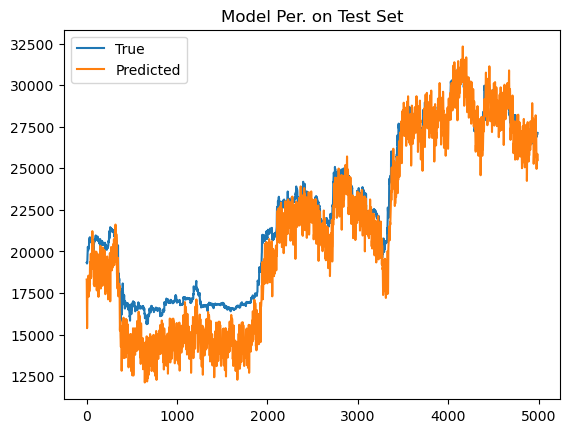

RSI_24_hourly
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 2359872.75, Test MAE: 1258.1529541015625


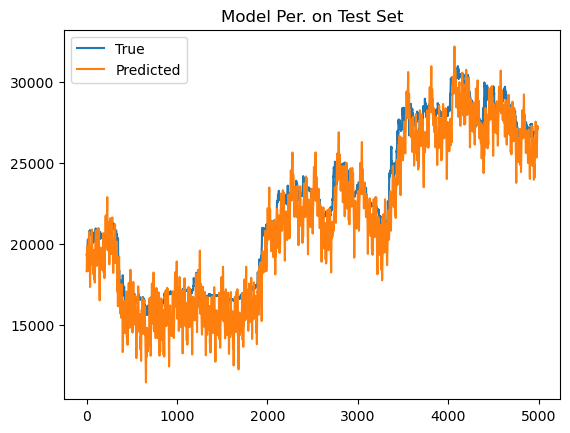

MACD_hourly
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 2656817.5, Test MAE: 1335.1112060546875


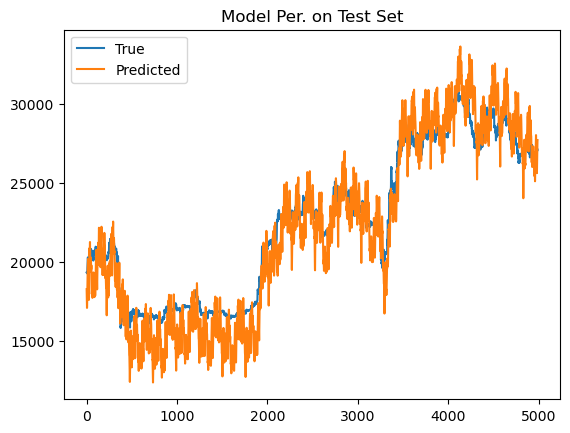

SMA_168_hourly
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 2974035.5, Test MAE: 1395.426025390625


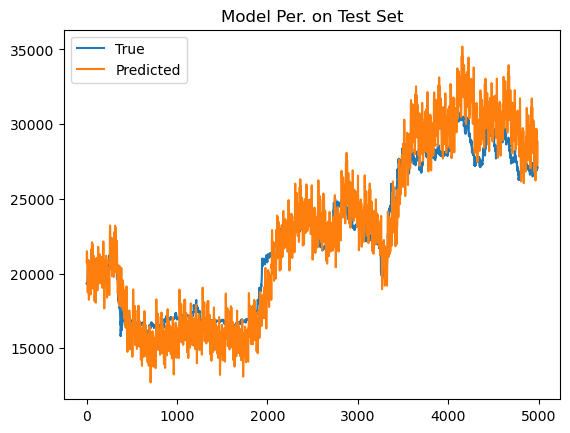

RSI_168_hourly
(79805, 36, 2)
(79805, 1)
torch.Size([79805, 36, 2])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
Early stopping triggered
Test MSE: 4139921.25, Test MAE: 1690.1270751953125


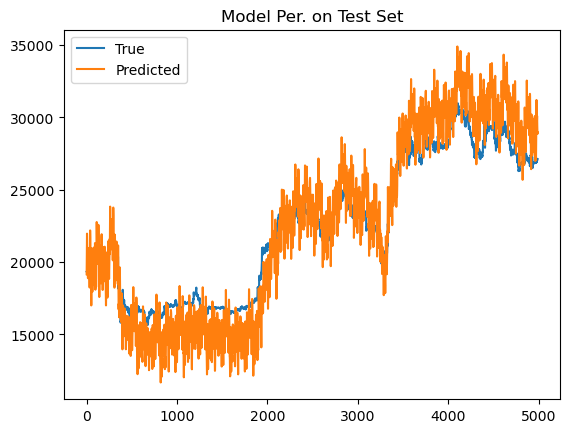

In [8]:
input_seq_len_ = 36
output_seq_len_ = 1
stats = {}
for cols in df.columns:
  if cols != "close":
    print(cols)
    # prepare temp_df
    temp_df = df[["close", cols]]

    # preprocesing temp_df
    scaled_df, scaler_general, scaler_close, train_dataloader, val_dataloader, test_dataloader = preprocess_data(temp_df,
                                                                                                             batch_size = 256,
                                                                                                             input_seq_len=input_seq_len_,
                                                                                                             output_seq_len=output_seq_len_)

    # instantiate model (after hyperparameter tuning)
    
    num_features = int(len(scaled_df.columns)) # a.k.a, number of cols in df
    num_layers = int(best["num_layers"])
    num_heads = int(best["num_heads"])
    d_model = int(best['d_model_by_num_heads']) * num_heads
    dff = int(best['dff'])
    mlp_size = int(best['mlp_size']) # size of the first MLP layer
    dropout_rate = round(best['dropout_rate'], 3)  # dropout rate for the Transformer layers
    mlp_dropout_rate = round(best['mlp_dropout_rate'], 3) # dropout rate for the MLP layers

    # instantiating model
    model = VanillaTimeSeriesTransformer_EncoderOnly(num_features, num_layers, d_model, num_heads, dff, output_seq_len_,
                                  output_seq_len_, mlp_size, dropout_rate, mlp_dropout_rate)

    # moving the model to the device (GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)


    criterion = MSELoss()
    optimiser = Adam(model.parameters(), lr=round(best['lr'], 6))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.9, patience=5)

    # declaring trainer object
    model_trainer = Trainer(model=model,
                  train_dataloader=train_dataloader,
                  val_dataloader=val_dataloader,
                  test_dataloader=test_dataloader,
                  criterion=criterion,
                  optimiser=optimiser,
                  scheduler=scheduler,
                  device=device,
                  num_epochs=50,
                  early_stopping_patience_limit=10,
                  is_save_model=True,
                  scaler=scaler_close)
    # training
    train_losses, val_losses = model_trainer.train_loop()
    # testing
    mse, mae = model_trainer.test_model()

    stats[cols] = {
        "mse":mse,
        "mae":mae
    }

with open('../data/stats_on_features_vanilla_transformer_hourly.pkl', 'wb') as file:
    pickle.dump(stats, file)

In [20]:
with open('../data/stats_on_features_vanilla_transformer_hourly.pkl', 'rb') as file:
    loaded_stats = pickle.load(file)
sorted_loaded_stats = OrderedDict(sorted(loaded_stats.items(), key=lambda item: item[1]['mse']))

# pprint(sorted_loaded_stats)

count = 0
top_feattures = []
for k,v in sorted_loaded_stats.items():
  if count < 10:
    top_feattures.append(k)
    count += 1
print(top_feattures)
with open('../data/top_feattures.pkl', 'wb') as file:
    pickle.dump(top_feattures, file)


['Difficulty', 'Transfer Volume (USDT)', '^GSPC', '^AXJO', '^N225', 'SI=F', 'Exchange Inflow Volume (Total) (USDT)', 'CL=F', '000001.SS', 'Stock-to-Flow Ratio ratio']


### Hyperparamer Tuning (Structural Tuning Too) for Top Features

In [3]:
df = pd.read_csv("../data/Final_data_hourly.csv")
with open('../data/top_feattures.pkl', 'rb') as file:
    top_feattures = pickle.load(file)
top_feattures.append("close")
df = df[top_feattures]

In [4]:
input_seq_len_ = 36
output_seq_len_ = 1
scaled_df, scaler_general, scaler_close, train_dataloader, val_dataloader, test_dataloader = preprocess_data(df,
                                                                                                             batch_size = 256,
                                                                                                             input_seq_len=input_seq_len_,
                                                                                                             output_seq_len=output_seq_len_)
def objective(params):
    print(f"""
    device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')},
    num_heads:  {params['num_heads']},
    d_model: {params['d_model_by_num_heads'] * params['num_heads']},
    num_layers: {params['num_layers']},
    dff: {params['dff']},
    mlp_size: {params['mlp_size']},
    dropout_rate: {params['dropout_rate']},
    mlp_dropout_rate: {params['mlp_dropout_rate']}""")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Use the parameters to define your model, train it and evaluate it.
    num_heads = params['num_heads']
    d_model = params['d_model_by_num_heads'] * num_heads
    model = VanillaTimeSeriesTransformer_EncoderOnly(
        num_features=int(len(scaled_df.columns)),
        num_layers=params['num_layers'],
        d_model=d_model,
        num_heads=num_heads,
        dff=params['dff'],
        input_seq_len=36,
        output_seq_len=1,
        mlp_size=params['mlp_size'],
        dropout_rate=params['dropout_rate'],
        mlp_dropout_rate=params['mlp_dropout_rate']
    )
    model = model.to(device)

    optimiser = Adam(model.parameters(), lr=params['lr'])
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.9, patience=5)
    criterion = MSELoss()

    model_trainer = Trainer(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                test_dataloader=test_dataloader,
                criterion=criterion,
                optimiser=optimiser,
                scheduler=scheduler,
                device=device,
                num_epochs=50,
                early_stopping_patience_limit=10,
                is_save_model=True,
                scaler=scaler_close)

    train_losses, val_losses = model_trainer.train_loop()

    # Return the last validation loss from the training loop
    return {'loss': val_losses[-1], 'status': STATUS_OK}

space = {
    'num_layers': scope.int(hp.quniform('num_layers', 1, 8, 1)),
    'num_heads': scope.int(hp.quniform('num_heads', 1, 8, 1)),
    'd_model_by_num_heads': scope.int(hp.quniform('d_model_by_num_heads', 32, 64, 2)),
    'dff': scope.int(hp.quniform('dff', 2, 2048, 1)),
    'mlp_size': scope.int(hp.quniform('mlp_size', 32, 64, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.3),
    'mlp_dropout_rate': hp.uniform('mlp_dropout_rate', 0.1, 0.3),
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.1))
}

# Run the optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print(best)

with open('../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl', 'wb') as file:
    pickle.dump(best, file)


(79805, 36, 11)
(79805, 1)
torch.Size([79805, 36, 11])
tensor([[[1.2532e-05]],

        [[1.2532e-05]],

        [[1.2532e-05]],

        ...,

        [[6.3629e-01]],

        [[6.3873e-01]],

        [[6.3064e-01]]])
                                                       
    device: cuda,
    num_heads:  2,
    d_model: 116,
    num_layers: 6,
    dff: 680,
    mlp_size: 61,
    dropout_rate: 0.2348705528814745,
    mlp_dropout_rate: 0.18386477949643498
Early stopping triggered                               
                                                                                       
    device: cuda,
    num_heads:  3,
    d_model: 102,
    num_layers: 4,
    dff: 868,
    mlp_size: 44,
    dropout_rate: 0.26621727144738494,
    mlp_dropout_rate: 0.29418502784637135
Early stopping triggered                                                               
                                                                                       
    device: cuda,
    num_heads:

### Training and Evaluation of Vanilla Transformer (Encoder only) on Close Price, Top 2, 5, 10

Close Price Only

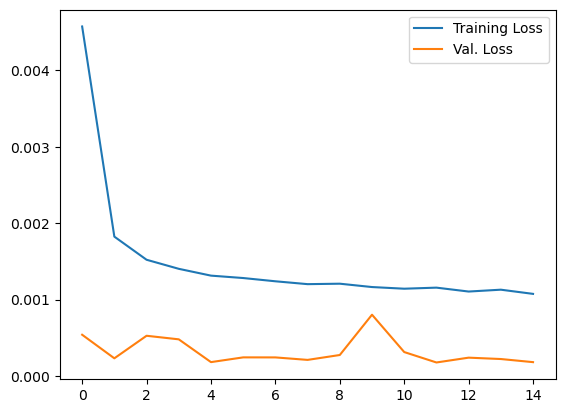

Current MAE 0.009875679140687944
Best MAE 0.009437090573487348
Early stopping triggered
Test MSE: 301068.84375, Test MAE: 431.8839111328125


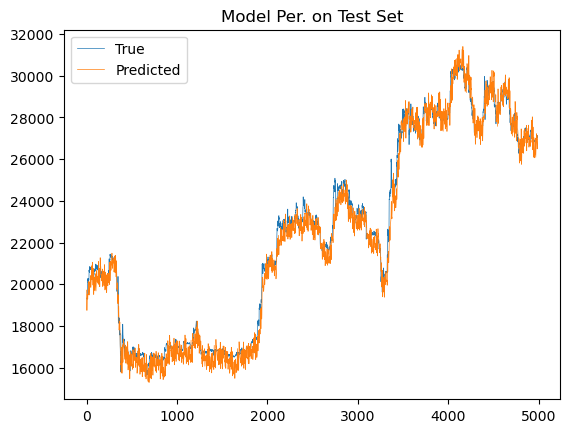

In [2]:
df = pd.read_csv("../data/Final_data_hourly.csv")
with open('../data/top_feattures.pkl', 'rb') as file:
    top_feattures = pickle.load(file)
# top_feattures = top_feattures[:1]
top_feattures.append("close")
df = df[["close"]]
# df
input_seq_len_ = 36
output_seq_len_ = 1
scaled_df, scaler_general, scaler_close, train_dataloader, val_dataloader, test_dataloader = preprocess_data(df,
                                                                                                             batch_size = 256,
                                                                                                             input_seq_len=input_seq_len_,
                                                                                                             output_seq_len=output_seq_len_)


with open('../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl', 'rb') as file:
    best = pickle.load(file)

# instantiating model (after hyperparameter tuning)

num_features = int(len(scaled_df.columns)) # a.k.a, number of cols in df
num_layers = int(best["num_layers"])
num_heads = int(best["num_heads"])
d_model = int(best['d_model_by_num_heads']) * num_heads
dff = int(best['dff'])
mlp_size = int(best['mlp_size']) # size of the first MLP layer
dropout_rate = round(best['dropout_rate'], 3)  # dropout rate for the Transformer layers
mlp_dropout_rate = round(best['mlp_dropout_rate'], 3) # dropout rate for the MLP layers

# instantiating model
model = VanillaTimeSeriesTransformer_EncoderOnly(num_features, num_layers, d_model, num_heads, dff, output_seq_len_,
                                output_seq_len_, mlp_size, dropout_rate, mlp_dropout_rate)

# moving the model to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


criterion = MSELoss() # L1Loss()
optimiser = Adam(model.parameters(), lr=round(best['lr'], 6))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.9, patience=5)

# declaring trainer object
model_trainer = Trainer(model=model,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            criterion=criterion,
            optimiser=optimiser,
            scheduler=scheduler,
            device=device,
            num_epochs=20,
            early_stopping_patience_limit=10,
            is_save_model=True,
            scaler=scaler_close)
# training
train_losses, val_losses = model_trainer.train_loop(is_plot=True, is_plot_and_plot_test=True)
# testing
mse, mae = model_trainer.test_model()


Top 2 features

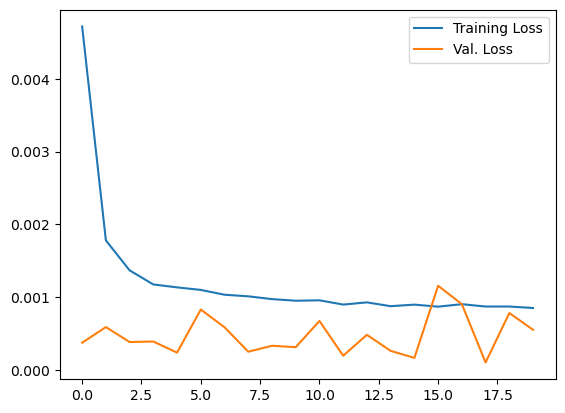

Current MAE 0.02242429502780378
Best MAE 0.007935390242322407
Test MSE: 2864530.25, Test MAE: 1633.46630859375


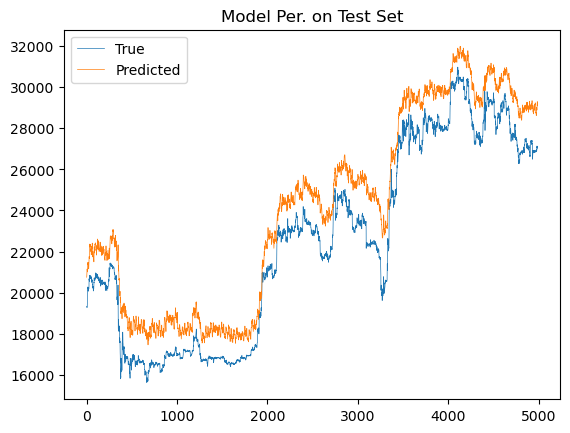

In [3]:
df = pd.read_csv("../data/Final_data_hourly.csv")
with open('../data/top_feattures.pkl', 'rb') as file:
    top_feattures = pickle.load(file)
top_feattures = top_feattures[:2]
top_feattures.append("close")
df = df[top_feattures]
input_seq_len_ = 36
output_seq_len_ = 1
scaled_df, scaler_general, scaler_close, train_dataloader, val_dataloader, test_dataloader = preprocess_data(df,
                                                                                                             batch_size = 256,
                                                                                                             input_seq_len=input_seq_len_,
                                                                                                             output_seq_len=output_seq_len_)


with open('../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl', 'rb') as file:
    best = pickle.load(file)

# instantiating model (after hyperparameter tuning)

num_features = int(len(scaled_df.columns)) # a.k.a, number of cols in df
num_layers = int(best["num_layers"])
num_heads = int(best["num_heads"])
d_model = int(best['d_model_by_num_heads']) * num_heads
dff = int(best['dff'])
mlp_size = int(best['mlp_size']) # size of the first MLP layer
dropout_rate = round(best['dropout_rate'], 3)  # dropout rate for the Transformer layers
mlp_dropout_rate = round(best['mlp_dropout_rate'], 3) # dropout rate for the MLP layers

# instantiating model
model = VanillaTimeSeriesTransformer_EncoderOnly(num_features, num_layers, d_model, num_heads, dff, output_seq_len_,
                                output_seq_len_, mlp_size, dropout_rate, mlp_dropout_rate)

# moving the model to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


criterion = MSELoss() # L1Loss()
optimiser = Adam(model.parameters(), lr=round(best['lr'], 6))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.9, patience=5)

# declaring trainer object
model_trainer = Trainer(model=model,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            criterion=criterion,
            optimiser=optimiser,
            scheduler=scheduler,
            device=device,
            num_epochs=20,
            early_stopping_patience_limit=10,
            is_save_model=True,
            scaler=scaler_close)
# training
train_losses, val_losses = model_trainer.train_loop(is_plot=True, is_plot_and_plot_test=True)
# testing
mse, mae = model_trainer.test_model()


Top 5 Features

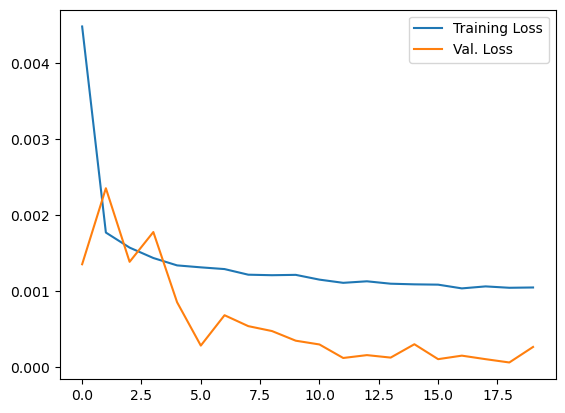

Current MAE 0.012486571876620448
Best MAE 0.006492979444769519
Test MSE: 746932.6875, Test MAE: 717.9661254882812


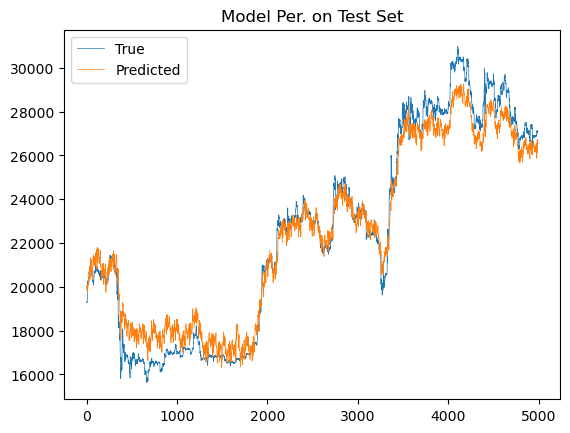

In [4]:
df = pd.read_csv("../data/Final_data_hourly.csv")
with open('../data/top_feattures.pkl', 'rb') as file:
    top_feattures = pickle.load(file)
top_feattures = top_feattures[:5]
top_feattures.append("close")
df = df[top_feattures]
input_seq_len_ = 36
output_seq_len_ = 1
scaled_df, scaler_general, scaler_close, train_dataloader, val_dataloader, test_dataloader = preprocess_data(df,
                                                                                                             batch_size = 256,
                                                                                                             input_seq_len=input_seq_len_,
                                                                                                             output_seq_len=output_seq_len_)


with open('../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl', 'rb') as file:
    best = pickle.load(file)

# instantiating model (after hyperparameter tuning)

num_features = int(len(scaled_df.columns)) # a.k.a, number of cols in df
num_layers = int(best["num_layers"])
num_heads = int(best["num_heads"])
d_model = int(best['d_model_by_num_heads']) * num_heads
dff = int(best['dff'])
mlp_size = int(best['mlp_size']) # size of the first MLP layer
dropout_rate = round(best['dropout_rate'], 3)  # dropout rate for the Transformer layers
mlp_dropout_rate = round(best['mlp_dropout_rate'], 3) # dropout rate for the MLP layers

# instantiating model
model = VanillaTimeSeriesTransformer_EncoderOnly(num_features, num_layers, d_model, num_heads, dff, output_seq_len_,
                                output_seq_len_, mlp_size, dropout_rate, mlp_dropout_rate)

# moving the model to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


criterion = MSELoss() # L1Loss()
optimiser = Adam(model.parameters(), lr=round(best['lr'], 6))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.9, patience=5)

# declaring trainer object
model_trainer = Trainer(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                test_dataloader=test_dataloader,
                criterion=criterion,
                optimiser=optimiser,
                scheduler=scheduler,
                device=device,
                num_epochs=20,
                early_stopping_patience_limit=10,
                is_save_model=True,
                scaler=scaler_close)
# training
train_losses, val_losses = model_trainer.train_loop(is_plot=True, is_plot_and_plot_test=True)
# testing
mse, mae = model_trainer.test_model()


Top 10 Features

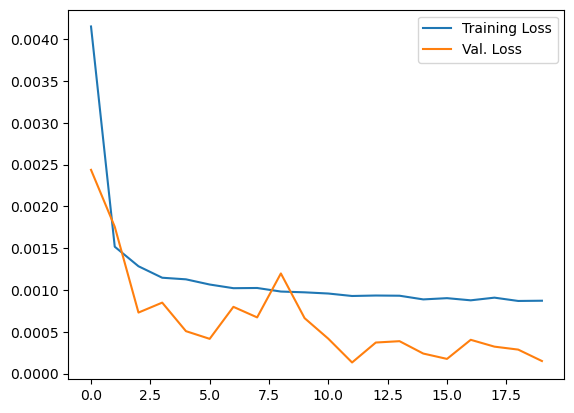

Current MAE 0.009621510733256554
Best MAE 0.008937847100753925
Test MSE: 2100481.5, Test MAE: 1262.593994140625


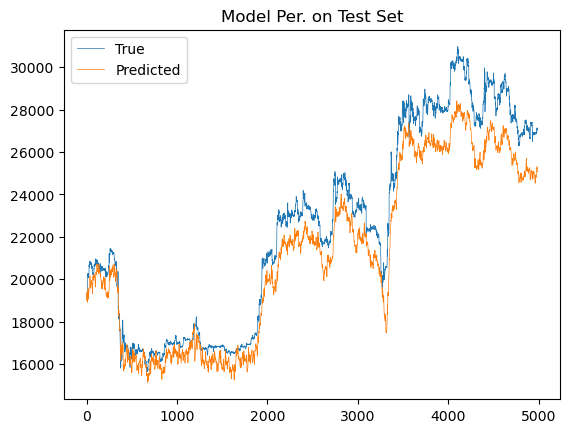

In [5]:
df = pd.read_csv("../data/Final_data_hourly.csv")
with open('../data/top_feattures.pkl', 'rb') as file:
    top_feattures = pickle.load(file)
top_feattures.append("close")
df = df[top_feattures]
input_seq_len_ = 36
output_seq_len_ = 1
scaled_df, scaler_general, scaler_close, train_dataloader, val_dataloader, test_dataloader = preprocess_data(df,
                                                                                                             batch_size = 256,
                                                                                                             input_seq_len=input_seq_len_,
                                                                                                             output_seq_len=output_seq_len_)


with open('../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl', 'rb') as file:
    best = pickle.load(file)

# instantiating model (after hyperparameter tuning)

num_features = int(len(scaled_df.columns)) # a.k.a, number of cols in df
num_layers = int(best["num_layers"])
num_heads = int(best["num_heads"])
d_model = int(best['d_model_by_num_heads']) * num_heads
dff = int(best['dff'])
mlp_size = int(best['mlp_size']) # size of the first MLP layer
dropout_rate = round(best['dropout_rate'], 3)  # dropout rate for the Transformer layers
mlp_dropout_rate = round(best['mlp_dropout_rate'], 3) # dropout rate for the MLP layers

# instantiating model
model = VanillaTimeSeriesTransformer_EncoderOnly(num_features, num_layers, d_model, num_heads, dff, output_seq_len_,
                                output_seq_len_, mlp_size, dropout_rate, mlp_dropout_rate)

# moving the model to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


criterion = MSELoss() # L1Loss()
optimiser = Adam(model.parameters(), lr=round(best['lr'], 6))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.9, patience=5)

# declaring trainer object
model_trainer = Trainer(model, train_dataloader, val_dataloader, test_dataloader, criterion, optimiser,
                scheduler, device, num_epochs=20, early_stopping_patience_limit=10,
                is_save_model=True, scaler=scaler_close)
model_trainer = Trainer(model=model,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            criterion=criterion,
            optimiser=optimiser,
            scheduler=scheduler,
            device=device,
            num_epochs=20,
            early_stopping_patience_limit=10,
            is_save_model=True,
            scaler=scaler_close)
# training
train_losses, val_losses = model_trainer.train_loop(is_plot=True, is_plot_and_plot_test=True)
# testing
mse, mae = model_trainer.test_model()


# Vanilla Transformer (Next 3rd Step Prediction | Encoder only)

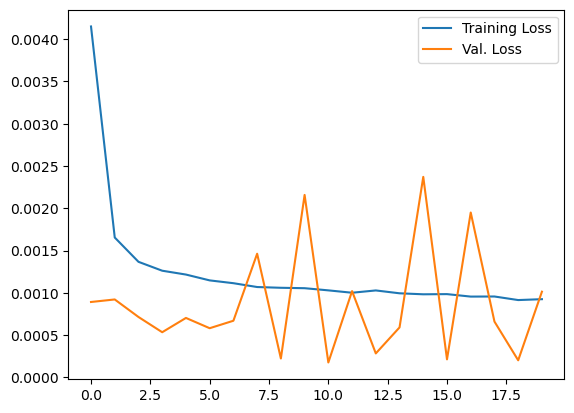

Current MAE 0.029282673108927147
Best MAE 0.009876827485006788
Test MSE: 670132.25, Test MAE: 608.2110595703125


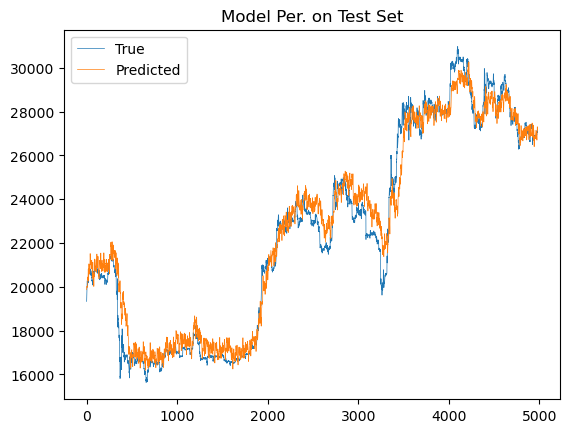

In [7]:
# data preprocessing
# training
df = pd.read_csv("../data/Final_data_hourly.csv")
with open('../data/top_feattures.pkl', 'rb') as file:
    top_feattures = pickle.load(file)
top_feattures = top_feattures[:2]
top_feattures.append("close")
df = df[top_feattures]
input_seq_len_ = 168
output_seq_len_ = 12
scaled_df, scaler_general, scaler_close, train_dataloader, val_dataloader, test_dataloader = preprocess_data(df,
                                                                                                             batch_size = 256,
                                                                                                             input_seq_len=input_seq_len_,
                                                                                                             output_seq_len=output_seq_len_,
                                                                                                             output_as_seq=False)


with open('../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl', 'rb') as file:
    best = pickle.load(file)

# instantiating model (after hyperparameter tuning)

num_features = int(len(scaled_df.columns)) # a.k.a, number of cols in df
num_layers = int(best["num_layers"])
num_heads = int(best["num_heads"])
d_model = int(best['d_model_by_num_heads']) * num_heads
dff = int(best['dff'])
mlp_size = int(best['mlp_size']) # size of the first MLP layer
dropout_rate = round(best['dropout_rate'], 3)  # dropout rate for the Transformer layers
mlp_dropout_rate = round(best['mlp_dropout_rate'], 3) # dropout rate for the MLP layers

# instantiating model
model = VanillaTimeSeriesTransformer_EncoderOnly(num_features, num_layers, d_model, num_heads, dff, output_seq_len_,
                                output_seq_len_, mlp_size, dropout_rate, mlp_dropout_rate)

# moving the model to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


criterion = MSELoss() # L1Loss()
optimiser = Adam(model.parameters(), lr=round(best['lr'], 6))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.9, patience=5)

# declaring trainer object
model_trainer = Trainer(model=model,
                  train_dataloader=train_dataloader,
                  val_dataloader=val_dataloader,
                  test_dataloader=test_dataloader,
                  criterion=criterion,
                  optimiser=optimiser,
                  scheduler=scheduler,
                  device=device,
                  num_epochs=20,
                  early_stopping_patience_limit=10,
                  is_save_model=True,
                  scaler=scaler_close)

# training
train_losses, val_losses = model_trainer.train_loop(is_plot=True, is_plot_and_plot_test=True)
# testing
mse, mae = model_trainer.test_model()



# Vanilla Transformer (Encoder-Decoder)

### Hyperparamer Tuning (Structural Tuning Too) for 2 Features


### Finding Top Features

### Hyperparamer Tuning (Structural Tuning Too) for Top Features